# Description

Runs VAE with standard parameters. It saves the model and generates plots.

# Modules

In [1]:
# reload imported modules if changed
%load_ext autoreload
%autoreload 2

import pprint

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pyreadr
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import dcor

from pvae import conf
from pvae.data import FeatherDataset
from pvae.models import VariationalAutoencoder
from pvae.models_utils import train_vae

# Settings and paths

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
display(DEVICE)

'cuda'

In [3]:
# Model parameters
K = 168
KL_L = 1.0
PRED_L = 2.0

# Others parameters
K_FOLDS = 3
N_FOLDS_TO_RUN = None  # None to run all K_FOLDS (used for testing)
N_EPOCS = 50
BATCH_SIZE = 50
PATHWAYS_TRAINING_PERC = 0.80
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.0
RANDOM_SEED = 0

In [4]:
# Paths
OUTPUT_FOLDER = (
    conf.data.OUTPUT_DIR
    / "models"
    / "mice_vae"
    / f"k_{K}-kl_l_{KL_L}-pred_l_{PRED_L}-batch_size_{BATCH_SIZE}-lr_{LEARNING_RATE:.0e}-n_epochs_{N_EPOCS}"
)
VAE_MODEL_OUTPUT_FILE = "fold_{fold}-mice_vae_model.pt"
DATA_SCALER_OUTPUT_FILE = "fold_{fold}-data_scaler.joblib"

In [5]:
# INPUT_FILES and OUTPUT_FILES must be provided if running with pytask
INPUT_FILES = {
    "mice_gene_expr_data_input": conf.data.MICE_PROCESSED_DIR
    / "mice_data-full-log.ftr",
    "mice_gene_expr_norm_adult_heart_input": conf.data.MICE_PROCESSED_DIR
    / "mice_gene_expr_norm_adult_heart_full_log.ftr",
    "mice_plier_model_Z": conf.data.MICE_PROCESSED_DIR
    / "mice_model_Z_std.csv",
    "mice_plier_model_B": conf.data.MICE_PROCESSED_DIR
    / "mice_model_B_std.csv"}

OUTPUT_FILES = {
    f"mice_vae_model_fold{i}": OUTPUT_FOLDER / VAE_MODEL_OUTPUT_FILE.format(fold=i)
    for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
}
OUTPUT_FILES.update(
    {
        f"data_scaler_fold{i}": OUTPUT_FOLDER / DATA_SCALER_OUTPUT_FILE.format(fold=i)
        for i in range(min(K_FOLDS, N_FOLDS_TO_RUN or K_FOLDS))
    }
)
OUTPUT_FILES.update({"performance_stats": OUTPUT_FOLDER / "performance_stats.pkl"})

In [6]:
pprint.pprint(INPUT_FILES)

{'mice_gene_expr_data_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_data-full-log.ftr'),
 'mice_gene_expr_norm_adult_heart_input': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_gene_expr_norm_adult_heart_full_log.ftr'),
 'mice_plier_model_B': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_model_B_std.csv'),
 'mice_plier_model_Z': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/input/mice_data/processed/mice_model_Z_std.csv')}


In [7]:
pprint.pprint(OUTPUT_FILES)

{'data_scaler_fold0': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_0-data_scaler.joblib'),
 'data_scaler_fold1': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_1-data_scaler.joblib'),
 'data_scaler_fold2': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_2-data_scaler.joblib'),
 'mice_vae_model_fold0': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_0-mice_vae_model.pt'),
 'mice_vae_model_fold1': PosixPath('/home/prashant/Documents/milton_lab/pvae/base/output/models/mice_vae/k_168-kl_l_1.0-pred_l_2.0-batch_size_50-lr_1e-04-n_epochs_50/fold_1-mice_vae_model.pt'),
 'mice_vae_model_fold2': PosixPath('

In [8]:
for _k, v in OUTPUT_FILES.items():
    v.parent.mkdir(parents=True, exist_ok=True)

# Load data

## FeatherDataset

In [9]:
dataset = FeatherDataset(INPUT_FILES["mice_gene_expr_data_input"], read_full_data=True)

In [10]:
dataset[:][0][torch.isnan(dataset[:][0])] = 0
dataset.data.shape
nan_mask = torch.isnan(dataset[:][0])
has_nan = torch.any(nan_mask)
print(nan_mask)
print(has_nan)
nan_indices = torch.nonzero(nan_mask)
print(nan_indices)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor(False)
tensor([], size=(0, 2), dtype=torch.int64)


In [11]:
display(dataset.length)
assert dataset.length == 190110

190110

In [12]:
dataset[0]

(tensor([1.4206, 1.4944, 3.2461,  ..., 1.3528, 1.5780, 1.3453]), tensor([]), 0)

## Get dataset dimensions

In [13]:
data_n_samples = dataset.length
display(data_n_samples)

data_n_genes = dataset[0][0].shape[0]
display(data_n_genes)

190110

10849

# VAE

In [14]:
random_state = np.random.RandomState(RANDOM_SEED)

In [15]:
def create_model():
    return VariationalAutoencoder(
        k=K,
        n_features=data_n_genes,
        n_samples=data_n_samples,
        n_pathways=0,
        kl_l=KL_L,
        pred_l=PRED_L,
    )

In [16]:
display(create_model())

/home/prashant/miniconda3/envs/pvae/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=168, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=168, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=168, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

# Load a model

In [17]:
_fold = 0

In [18]:
train_data_scaler = joblib.load(OUTPUT_FILES[f"data_scaler_fold{_fold}"])
display(train_data_scaler)

StandardScaler()

In [19]:
model = create_model()
model.load_state_dict(torch.load(OUTPUT_FILES[f"mice_vae_model_fold{_fold}"]))
model.to("cpu")
model.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=10849, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (mu_layer): Linear(in_features=512, out_features=168, bias=True)
    (sigma_layer): Linear(in_features=512, out_features=168, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=168, out_features=512, bias=True)
    (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear_recon): Linear(in_features=512, out_features=10849, bias=True)
  )
  (predictor): PathwaysPredictor(
    (pathway_prediction): Sequential(
      (0): Linear(in_features=190110, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=0, bias=True)
  

# Save

In [20]:
data = pd.read_feather(INPUT_FILES["mice_gene_expr_data_input"]).set_index("index")

In [21]:
orig_data = torch.as_tensor(
    train_data_scaler.transform(data.T.to_numpy()), dtype=torch.float32
).detach()

In [22]:
orig_data.shape

torch.Size([190110, 10849])

## Latent space

In [23]:
z = model.encoder(orig_data).detach().numpy()

In [24]:
z.shape

(190110, 168)

In [25]:
z = pd.DataFrame(
    data=z, index=data.columns.tolist(), columns=[f"lv{i}" for i in range(K)]
)

In [26]:
z.head()

,lv0,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,...,lv158,lv159,lv160,lv161,lv162,lv163,lv164,lv165,lv166,lv167
SRR1557113,0.136870,-1.708765,-0.700191,0.540391,0.872450,1.024137,-0.645510,-0.377394,-0.076312,-0.156162,...,-0.940475,-0.281987,-0.895432,0.824832,-0.897152,0.525082,0.177508,-1.085736,0.632062,-0.229843
SRR1557114,-0.281888,-1.277565,-0.039616,-0.450075,0.624850,1.102944,-0.913706,0.173679,0.999653,-0.403724,...,-1.529628,-1.006354,0.163159,-0.313857,-0.801623,-0.874438,-0.530950,-1.079825,1.159112,-0.391264
SRR1557115,0.641235,-1.718702,-0.233781,-0.129872,0.419226,1.237040,-0.626505,-0.223330,-0.148602,0.036476,...,-0.423260,0.080330,-0.807800,0.649312,-0.754880,-0.361683,0.215907,-1.119656,0.952062,-0.555425
SRR1557116,0.434536,-1.453278,-0.051387,-0.048853,0.280368,1.411937,-0.874183,-0.634318,0.437547,0.254373,...,-0.628924,-0.486713,-0.116187,0.284158,-0.868449,-0.051913,0.013937,-0.689078,0.186353,-0.674261
SRR1557117,0.571863,0.143960,-0.203807,-0.293403,0.515404,1.311698,-1.009655,0.898220,0.307200,0.177235,...,-0.251671,-0.418711,-0.209933,-0.346585,0.007985,-0.531164,-0.455640,-1.096450,-0.351623,-0.378933


In [27]:
# z.to_pickle(OUTPUT_FILES["pvae_latent_space"])

## Reconstructed data

In [28]:
data_recon = model.forward(orig_data).detach()

In [29]:
data_recon.shape

torch.Size([190110, 10849])

In [30]:
data_recon

tensor([[ 8.6079e-02,  1.0514e-01,  4.5918e+00,  ..., -1.8252e+00,
         -1.6885e-01, -7.9072e-02],
        [-2.4486e-03,  7.7607e-02,  3.0469e+00,  ..., -1.5366e+00,
         -8.1408e-02, -6.2559e-02],
        [ 6.1390e-03,  1.7507e-01,  3.4336e+00,  ..., -1.2716e+00,
          1.2478e-01,  4.5908e-02],
        ...,
        [-5.1327e-01, -3.4840e-01,  9.7447e-01,  ...,  1.1502e+00,
          2.9479e-01, -7.5550e-02],
        [-4.4904e-01, -3.1188e-01,  8.9668e-01,  ...,  1.1242e+00,
         -1.0845e-01,  5.4661e-02],
        [-4.9430e-01, -3.2016e-01,  1.0317e+00,  ...,  1.1669e+00,
          2.3049e-02,  1.5329e-03]])

In [31]:
data_recon_df = pd.DataFrame(
    data=data_recon.T.detach().numpy(),
    index=data.index.tolist(),
    columns=data.columns.tolist(),
)

In [32]:
data_recon_df.shape

(10849, 190110)

In [33]:
data_recon_df.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
Xkr4,0.086079,-0.002449,0.006139,0.034358,0.133681,0.138321,0.085781,0.391008,0.275444,0.493232,...,0.923634,0.836643,0.635104,0.784626,-0.376514,-0.465096,-0.339827,-0.513265,-0.449044,-0.494301
Sox17,0.105136,0.077607,0.175065,0.768826,-0.029858,0.543211,0.131396,0.197347,-0.044281,0.131974,...,0.042786,-0.194720,0.014765,0.006929,-0.500594,-0.488650,-0.592582,-0.348404,-0.311877,-0.320162
Mrpl15,4.591823,3.046890,3.433648,2.684787,-0.036946,0.533817,0.451564,1.421298,0.403372,0.790826,...,-0.603470,-0.630167,-0.582090,-0.611167,1.342598,1.324103,1.244228,0.974469,0.896680,1.031666
Lypla1,3.075365,2.121944,2.548265,2.448662,-0.203690,0.446712,0.312962,1.097538,0.299557,0.647609,...,-0.361809,-0.333477,-0.462533,-0.437656,1.101383,1.139441,1.200183,0.728900,0.796579,0.766708
Tcea1,4.085032,2.999152,3.593752,3.057412,0.524595,0.999216,0.943132,2.180924,1.163501,1.660090,...,0.318757,0.132236,0.113238,0.239510,1.299853,1.203489,1.418431,0.846826,0.678971,0.829659


In [34]:
# data_recon_df.to_pickle(OUTPUT_FILES["pvae_data_recon"])

# MSE

In [35]:
_l = nn.MSELoss()
display(_l(data_recon, orig_data))

tensor(0.2039)

In [36]:
_l = nn.MSELoss(reduction="sum")
display(_l(data_recon, orig_data))

tensor(4.2053e+08)

# Plot

In [37]:
scaler = StandardScaler().set_output(transform="pandas")
z_scaled = scaler.fit_transform(z)

In [38]:
z_scaled.head()

,lv0,lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9,...,lv158,lv159,lv160,lv161,lv162,lv163,lv164,lv165,lv166,lv167
SRR1557113,0.190235,-2.857270,-0.906079,0.907624,1.232008,1.219731,-0.986982,-0.444854,-0.140728,-0.224476,...,-1.284485,-0.444310,-1.263628,1.071710,-1.349575,0.823043,0.226574,-1.239866,0.983080,-0.367171
SRR1557114,-0.407404,-2.138232,-0.023474,-0.558287,0.891943,1.315228,-1.405705,0.307392,1.529272,-0.599501,...,-2.080518,-1.452201,0.215216,-0.388070,-1.205638,-1.262230,-0.934307,-1.233212,1.822461,-0.635172
SRR1557115,0.910048,-2.873840,-0.282901,-0.084380,0.609531,1.477720,-0.957311,-0.234547,-0.252928,0.067346,...,-0.585650,0.059823,-1.141207,0.846696,-1.135209,-0.498228,0.289495,-1.278046,1.492713,-0.907724
SRR1557116,0.615054,-2.431238,-0.039203,0.035530,0.418818,1.689656,-1.344000,-0.795569,0.656830,0.397432,...,-0.863533,-0.729167,-0.175028,0.378576,-1.306328,-0.036674,-0.041454,-0.793387,0.273242,-1.105023
SRR1557117,0.811044,0.232199,-0.242853,-0.326409,0.741625,1.568189,-1.555507,1.296431,0.454520,0.280578,...,-0.353807,-0.634548,-0.305991,-0.430026,0.014226,-0.750754,-0.810904,-1.251925,-0.583539,-0.614699


## Latent space

### PCA

In [39]:
pca = PCA(n_components=4, random_state=0).set_output(transform="pandas")
z_pca = pca.fit_transform(z_scaled)

In [40]:
z_pca.shape

(190110, 4)

In [41]:
z_pca.head()

,pca0,pca1,pca2,pca3
SRR1557113,1.017438,-3.656940,2.570364,1.668254
SRR1557114,1.478595,-4.130097,3.193334,1.802231
SRR1557115,0.843934,-3.521768,2.611732,1.597434
SRR1557116,0.824789,-3.085924,2.260911,0.954862
SRR1557117,0.511045,-2.533248,1.608301,1.804676


In [42]:
# df_plot = z_pca.assign(tissue=sample_tissues["simplified_tissue"])

In [43]:
# df_plot

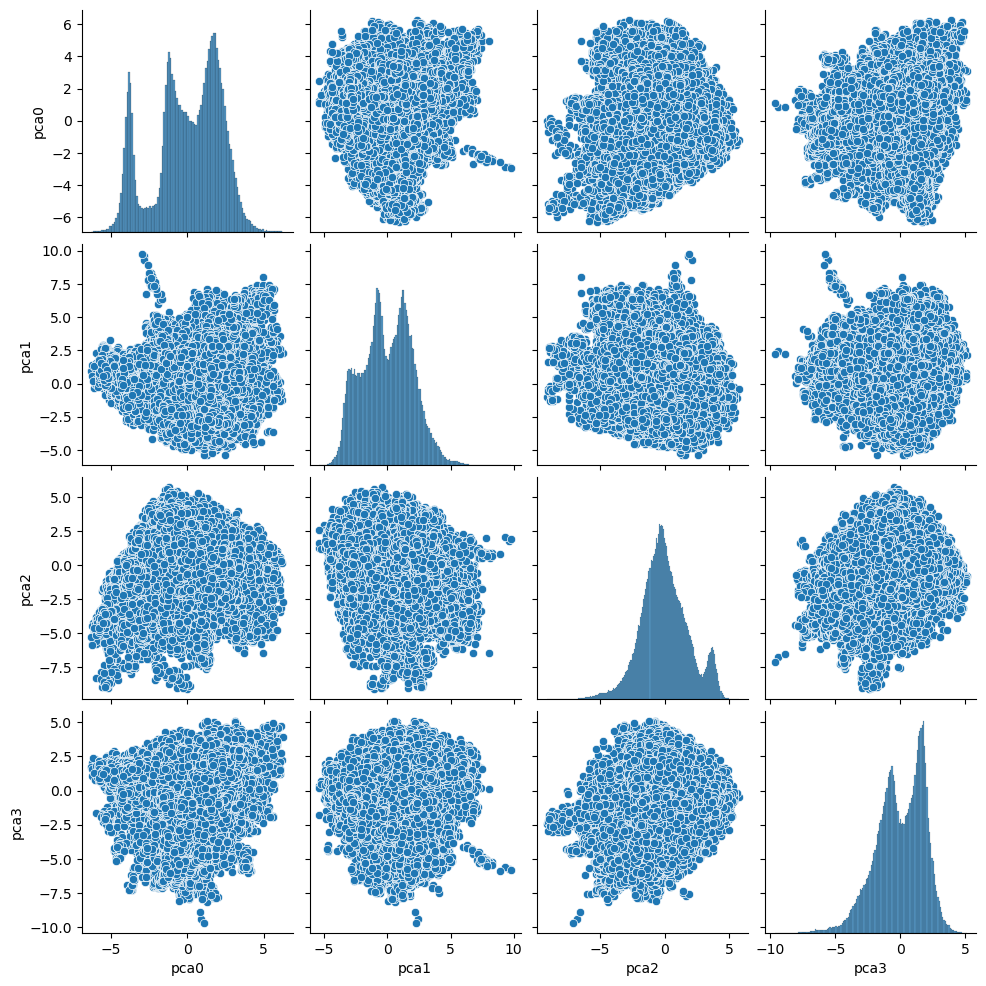

In [44]:
# sns.set_theme(style="ticks", palette="tab10")
sns.pairplot(data=z_pca)

# PLIER B Matrix (Mice)

In [45]:
df_Z = pd.read_csv(INPUT_FILES['mice_plier_model_Z'])
df_Z = df_Z.set_index("Unnamed: 0").rename_axis(index=None)
df_Z.head()

df_B = pd.read_csv(INPUT_FILES['mice_plier_model_B'])
df_B = df_B.set_index("Unnamed: 0").rename_axis(index=None)
df_B = df_B.drop('SRR1557112', axis=1)
df_B.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
LV1,-0.268300,-0.670830,-0.345494,-0.342450,-0.243202,-0.441225,-0.485892,-0.392068,-0.590909,-0.417210,...,-0.304969,-0.319332,-0.317460,-0.369937,-0.429210,-0.419838,-0.447235,-0.182112,-0.192730,-0.186131
LV2,6.929067,6.082590,7.217676,6.832574,5.376394,3.370360,2.939453,4.769698,1.928760,3.046538,...,-0.693722,-0.669089,-0.688071,-0.789017,1.338567,1.467901,1.681187,0.149112,0.168866,0.337082
LV3,-0.842621,-0.523059,-0.798890,-0.429208,-0.253698,-0.393508,-0.310057,0.202168,-0.440780,0.003509,...,-0.323053,-0.350793,-0.379952,-0.381803,-2.475072,-2.458526,-2.419827,-2.613561,-2.637285,-2.661207
LV4,-0.568899,-0.564029,-0.777056,-0.793276,-0.573627,-0.831882,-0.559707,-0.775470,-0.616133,-0.681189,...,-0.670272,-0.645243,-0.681386,-0.738590,-0.342178,-0.340178,-0.341281,-0.396643,-0.411333,-0.423334
LV5,-0.253184,-1.166073,0.394377,1.655300,1.916110,3.755178,2.244068,5.938345,4.142249,5.378181,...,-0.341496,-0.277329,-0.492183,-0.553289,-2.608217,-2.601724,-2.659227,-1.733880,-1.768234,-1.788621


In [46]:
scaler = StandardScaler().set_output(transform="pandas")
z_B_scaled = scaler.fit_transform(df_B.T)

In [47]:
pca = PCA(n_components=4, random_state=0).set_output(transform="pandas")
z_B_pca = pca.fit_transform(z_B_scaled)

In [48]:
z_B_pca.shape

(190110, 4)

In [49]:
z_B_pca.head()

,pca0,pca1,pca2,pca3
SRR1557113,-0.364915,0.005046,0.088776,0.597097
SRR1557114,1.002290,-0.777897,0.838901,-0.519341
SRR1557115,-0.536352,-0.378634,0.039587,0.489661
SRR1557116,0.392584,-0.579728,0.143644,0.001702
SRR1557117,2.982066,-2.486995,2.065386,0.400470


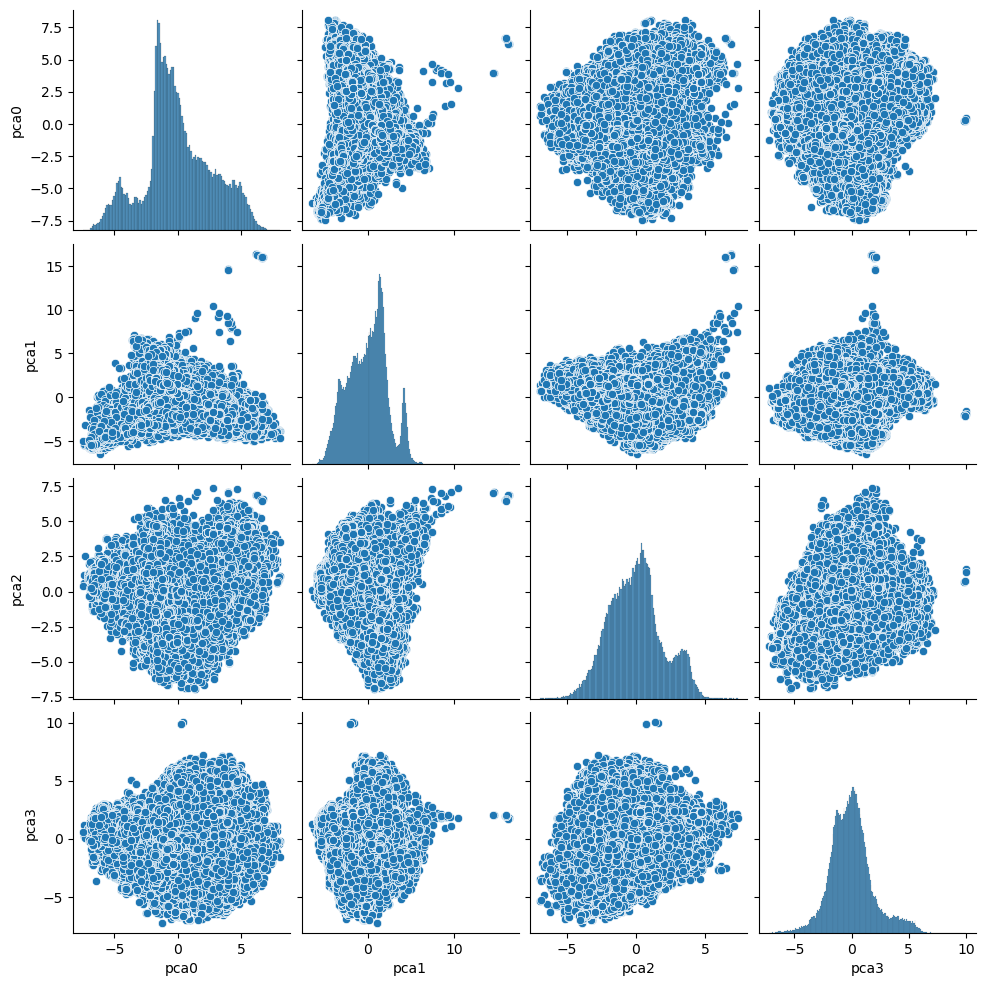

In [50]:
sns.pairplot(data=z_B_pca)

In [51]:
df_B.shape
df_B.head()
# df_B.columns

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
LV1,-0.268300,-0.670830,-0.345494,-0.342450,-0.243202,-0.441225,-0.485892,-0.392068,-0.590909,-0.417210,...,-0.304969,-0.319332,-0.317460,-0.369937,-0.429210,-0.419838,-0.447235,-0.182112,-0.192730,-0.186131
LV2,6.929067,6.082590,7.217676,6.832574,5.376394,3.370360,2.939453,4.769698,1.928760,3.046538,...,-0.693722,-0.669089,-0.688071,-0.789017,1.338567,1.467901,1.681187,0.149112,0.168866,0.337082
LV3,-0.842621,-0.523059,-0.798890,-0.429208,-0.253698,-0.393508,-0.310057,0.202168,-0.440780,0.003509,...,-0.323053,-0.350793,-0.379952,-0.381803,-2.475072,-2.458526,-2.419827,-2.613561,-2.637285,-2.661207
LV4,-0.568899,-0.564029,-0.777056,-0.793276,-0.573627,-0.831882,-0.559707,-0.775470,-0.616133,-0.681189,...,-0.670272,-0.645243,-0.681386,-0.738590,-0.342178,-0.340178,-0.341281,-0.396643,-0.411333,-0.423334
LV5,-0.253184,-1.166073,0.394377,1.655300,1.916110,3.755178,2.244068,5.938345,4.142249,5.378181,...,-0.341496,-0.277329,-0.492183,-0.553289,-2.608217,-2.601724,-2.659227,-1.733880,-1.768234,-1.788621


In [52]:
z_scaled.shape
z_scaled_T = z_scaled.T 
z_scaled_T.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
lv0,0.190235,-0.407404,0.910048,0.615054,0.811044,-0.104617,-0.204579,-0.264216,-0.492713,-0.213948,...,2.764355,2.668238,2.406782,2.379505,-1.086502,-1.041493,-0.987822,-0.854354,-0.590051,-0.379512
lv1,-2.857270,-2.138232,-2.873840,-2.431238,0.232199,-1.281049,-0.305834,-1.919925,-1.470596,-2.343732,...,-2.952311,-2.733908,-2.390560,-2.378822,-1.160394,-1.130353,-0.787629,-1.532960,-1.491071,-1.012838
lv2,-0.906079,-0.023474,-0.282901,-0.039203,-0.242853,-1.606489,-1.507309,-0.618043,-0.362831,0.001840,...,-0.922317,-0.650143,-0.859263,-0.667029,-0.746390,-0.693572,-0.632342,-1.055941,-0.945908,-1.325370
lv3,0.907624,-0.558287,-0.084380,0.035530,-0.326409,-0.596515,-1.386989,-0.691876,-0.882520,-0.773818,...,1.203350,0.899559,1.231337,0.735059,0.753626,0.703446,0.677109,1.079897,0.849766,1.120125
lv4,1.232008,0.891943,0.609531,0.418818,0.741625,-0.450870,-0.958293,0.682312,-0.256522,0.873416,...,-1.165574,-1.040215,-0.926985,-1.358424,-0.737300,-0.434861,-0.872649,0.130768,0.156500,-0.086984


In [53]:
coexp_save_folder = '/home/prashant/Documents/milton_lab/pvae/base/output/mice_gene_gene_coexp/'

# Gene Gene coexpression matrix (PLIER) #

In [54]:
Plier_Z_tensor = torch.tensor(df_Z.values, dtype=torch.float32)
Plier_Z_norm_tensor = F.normalize(Plier_Z_tensor, dim=1)
Plier_Z_norm_tensor_gpu = Plier_Z_norm_tensor.to(DEVICE)
Plier_gene_gene_coexp_gpu = torch.matmul(Plier_Z_norm_tensor_gpu, Plier_Z_norm_tensor_gpu.T)
Plier_gene_gene_coexp_cpu = Plier_gene_gene_coexp_gpu.cpu()
Plier_gene_gene_coexp_df = pd.DataFrame(Plier_gene_gene_coexp_cpu.numpy())
Plier_gene_gene_coexp_df.index = df_Z.index
Plier_gene_gene_coexp_df.columns = df_Z.index
Plier_gene_gene_coexp_df.head()
display(Plier_gene_gene_coexp_df.shape)
Plier_gene_gene_coexp_df.to_csv(coexp_save_folder + "Plier_gene_gene_coexp.csv")

(10781, 10781)

# Gene Gene coexpression matrix (VAE) #

In [55]:
data = pd.read_feather(INPUT_FILES["mice_gene_expr_data_input"]).set_index("index")
orig_data = torch.as_tensor(
    train_data_scaler.transform(data.T.to_numpy()), dtype=torch.float32
).detach()
orig_data_df = pd.DataFrame(
    data=orig_data.T, index=data.index.tolist(), columns=data.columns.tolist())
orig_data_df.head()
orig_data_tensor = torch.tensor(orig_data_df.values, dtype=torch.float32)
orig_data_tensor_gpu = orig_data_tensor.to(DEVICE)

z_gpu = torch.tensor(z.values, dtype=torch.float32).to(DEVICE)

orig_data_z_gpu = torch.matmul(orig_data_tensor_gpu, z_gpu)
z_z_T_gpu = torch.matmul(z_gpu.T, z_gpu)
z_z_T_inv_gpu = torch.linalg.inv(z_z_T_gpu)
Vae_Z_gpu = torch.matmul(orig_data_z_gpu, z_z_T_inv_gpu)
Vae_Z_cpu = Vae_Z_gpu.cpu().numpy()
Vae_Z_df = pd.DataFrame(
    data=Vae_Z_cpu, index=data.index.tolist(), columns=[f"LV{i}" for i in range(K)])


Vae_Z_tensor = torch.tensor(Vae_Z_df.values, dtype=torch.float32)
Vae_Z_norm_tensor = F.normalize(Vae_Z_tensor, dim=1)
Vae_Z_norm_tensor_gpu = Vae_Z_norm_tensor.to(DEVICE)
Vae_gene_gene_coexp_gpu = torch.matmul(Vae_Z_norm_tensor_gpu, Vae_Z_norm_tensor_gpu.T)
Vae_gene_gene_coexp_cpu = Vae_gene_gene_coexp_gpu.cpu()
Vae_gene_gene_coexp_df = pd.DataFrame(Vae_gene_gene_coexp_cpu.numpy())
Vae_gene_gene_coexp_df.index = Vae_Z_df.index
Vae_gene_gene_coexp_df.columns = Vae_Z_df.index
Vae_gene_gene_coexp_df.head()
display(Vae_gene_gene_coexp_df.shape)
Vae_gene_gene_coexp_df.to_csv(coexp_save_folder + "Vae_gene_gene_coexp.csv")

(10849, 10849)

# Not all genes are in Plie and VAE. Take Common Genes #

In [56]:
set1 = set(Vae_gene_gene_coexp_df.columns.tolist())
set2 = set(Plier_gene_gene_coexp_df.columns.tolist())
common = list(set1.intersection(set2))
display(len(common))
Vae_gene_gene_coexp_common_df = Vae_gene_gene_coexp_df.loc[common, common]
Plier_gene_gene_coexp_common_df = Plier_gene_gene_coexp_df.loc[common, common] 
display(Vae_gene_gene_coexp_common_df.shape, Plier_gene_gene_coexp_common_df.shape)

Vae_gene_gene_coexp_common_df.to_csv(coexp_save_folder + "Vae_gene_gene_coexp_common_genes.csv")
Plier_gene_gene_coexp_common_df.to_csv(coexp_save_folder + "Plier_gene_gene_coexp_common_genes.csv")

10036

(10036, 10036)

(10036, 10036)

In [57]:
Vae_gene_gene_coexp_common_df.head()

,B3galnt2,Mdk,Cers2,Accsl,Fem1a,H2-Aa,Iapp,Cenpn,S1pr5,Thra,...,Pigr,Rrp7a,Nr4a1,Crkl,Stxbp5,Amn,Slc6a11,Tmem59,Abcg5,Dkc1
B3galnt2,1.000000,0.068805,0.002135,0.113268,0.276982,-0.024450,-0.032395,0.132491,-0.078298,-0.121834,...,-0.100344,0.131126,-0.074589,0.321352,0.164737,-0.004986,-0.117344,-0.134021,-0.121520,0.119604
Mdk,0.068805,1.000000,-0.052276,-0.032651,-0.067717,-0.004750,-0.073946,0.096845,0.007264,-0.065943,...,-0.078536,-0.005606,-0.036493,0.127190,-0.136273,0.054441,-0.069974,-0.097581,-0.099145,0.073641
Cers2,0.002135,-0.052276,1.000000,-0.068613,-0.114202,0.031233,-0.110643,-0.057855,0.114118,-0.273770,...,0.082343,0.002702,-0.045075,0.027709,-0.052158,0.050365,-0.054491,0.182139,0.261944,0.017896
Accsl,0.113268,-0.032651,-0.068613,1.000000,-0.079368,0.038398,0.043162,0.507640,-0.033233,-0.000718,...,-0.037043,-0.020787,0.009032,-0.002393,0.086694,-0.010021,-0.024473,-0.003407,0.019764,0.100482
Fem1a,0.276982,-0.067717,-0.114202,-0.079368,1.000000,0.021645,0.010147,-0.102178,-0.052980,0.135546,...,-0.036921,0.063507,-0.034665,0.066140,0.032308,-0.021662,-0.035943,-0.145714,-0.104709,-0.076039


In [58]:
Plier_gene_gene_coexp_common_df.head()

,B3galnt2,Mdk,Cers2,Accsl,Fem1a,H2-Aa,Iapp,Cenpn,S1pr5,Thra,...,Pigr,Rrp7a,Nr4a1,Crkl,Stxbp5,Amn,Slc6a11,Tmem59,Abcg5,Dkc1
B3galnt2,1.000000,-0.057718,0.146786,0.031383,0.342894,-0.147521,-0.210384,-0.001437,-0.087269,-0.214515,...,-0.130068,0.105175,-0.094639,0.279191,0.236656,-0.133067,-0.212302,-0.038188,-0.108938,-0.021183
Mdk,-0.057718,1.000000,-0.031005,0.019649,-0.102596,-0.011023,0.024033,-0.000267,-0.019908,-0.072071,...,-0.001101,-0.030311,0.029141,-0.027551,-0.136861,0.038412,-0.016454,-0.072458,0.000886,0.078712
Cers2,0.146786,-0.031005,1.000000,-0.103814,0.076911,-0.020522,-0.147347,-0.108292,0.058816,-0.163421,...,-0.064380,0.043232,-0.003281,0.067220,0.049892,-0.018301,-0.128375,0.093265,0.096333,-0.061542
Accsl,0.031383,0.019649,-0.103814,1.000000,-0.111267,0.041238,0.135503,0.655539,0.035227,0.023799,...,0.073148,-0.085826,0.014298,-0.165038,-0.011780,0.027277,0.041740,-0.026223,0.059587,0.128496
Fem1a,0.342894,-0.102596,0.076911,-0.111267,1.000000,-0.051289,-0.045482,-0.087840,-0.056652,0.026833,...,-0.070269,0.048092,-0.069315,0.111801,0.063032,-0.081356,-0.104216,-0.083199,0.001371,-0.085668


# Gene Gene Coexpression Matrix (Original data) #

In [59]:
orig_data_df.head()

,SRR1557113,SRR1557114,SRR1557115,SRR1557116,SRR1557117,SRR1557118,SRR1557119,SRR1557120,SRR1557121,SRR1557122,...,ERR1082767,ERR1082768,ERR1082769,ERR1082770,SRR5445512,SRR5445513,SRR5445514,SRR5445515,SRR5445516,SRR5445517
Xkr4,-0.391117,-0.289622,-0.253313,-0.155910,-0.417694,-0.425542,-0.432708,-0.434004,-0.424488,-0.427128,...,0.704813,0.758403,0.288763,0.366957,-0.430025,-0.436023,-0.436023,-0.436023,-0.436023,-0.427011
Sox17,-0.346376,-0.361055,-0.214679,3.628929,-0.398270,-0.398270,-0.396887,-0.398270,-0.398270,-0.398270,...,0.002563,-0.029185,0.021326,0.021914,-0.368885,-0.398270,-0.383136,-0.377223,-0.369931,-0.398270
Mrpl15,4.604212,2.849991,3.248142,2.197406,-0.389206,0.350806,-0.033574,1.460415,0.436456,1.046423,...,-0.662173,-0.745663,-0.724444,-0.722006,1.130423,0.892533,1.214839,0.628698,0.611388,0.680339
Lypla1,3.727921,3.400404,3.506753,3.716021,-1.030461,-0.619319,-0.895211,-0.356186,-0.882881,-0.665650,...,-0.124162,-0.280598,-0.134133,-0.275682,0.792816,0.821195,1.041782,0.285318,0.330619,0.403254
Tcea1,5.073277,3.765444,4.519284,3.736548,0.447810,1.432658,1.035825,1.711415,0.490097,1.533066,...,0.412815,0.568092,0.399651,0.257337,1.308737,1.309025,1.354740,0.160343,0.415076,0.397425


In [60]:
ori_Z_tensor = torch.tensor(orig_data_df.values, dtype=torch.float32)
ori_Z_norm_tensor = F.normalize(ori_Z_tensor, dim=1)
ori_Z_norm_tensor_gpu = ori_Z_norm_tensor.to(DEVICE)
ori_gene_gene_coexp_gpu = torch.matmul(ori_Z_norm_tensor_gpu, ori_Z_norm_tensor_gpu.T)
ori_gene_gene_coexp_cpu = ori_gene_gene_coexp_gpu.cpu()
ori_gene_gene_coexp_df = pd.DataFrame(ori_gene_gene_coexp_cpu.numpy())
ori_gene_gene_coexp_df.index = orig_data_df.index
ori_gene_gene_coexp_df.columns = orig_data_df.index
ori_gene_gene_coexp_df.head()
display(ori_gene_gene_coexp_df.shape)
ori_gene_gene_coexp_df.to_csv(coexp_save_folder + "ori_gene_gene_coexp.csv")
ori_gene_gene_coexp_common_df = ori_gene_gene_coexp_df.loc[common, common]
display(ori_gene_gene_coexp_common_df.shape)
ori_gene_gene_coexp_common_df.to_csv(coexp_save_folder + "ori_gene_gene_coexp_common_genes.csv")

(10849, 10849)

(10036, 10036)

In [61]:
# pca = PCA(n_components=0.80, random_state=0).set_output(transform="pandas")
# df_B_pca = pca.fit_transform(df_B)
# display(df_B_pca.shape)

# pca = PCA(n_components=0.80, random_state=0).set_output(transform="pandas")
# z_scaledT_pca = pca.fit_transform(z_scaled.T)
# display(z_scaledT_pca.shape)

In [62]:
# corr_dict_pcorr = {}
# corr_dict_scorr = {}
# pvae_lv_names = dict.fromkeys(z_scaled.columns)
# for row1 in df_B.T.items():
#     row1_name = row1[0]
#     plier_lv_vec = row1[1].values
#     corr_dict_pcorr[row1_name] = {"LV" + lv_name.split("lv")[1]: None for lv_name in pvae_lv_names}
#     corr_dict_scorr[row1_name] = {"LV" + lv_name.split("lv")[1]:None for lv_name in pvae_lv_names}
#     print("Currently on row :", row1_name)
#     for row2 in z_scaled.items():
#         row2_name = "LV" + row2[0].split("lv")[1]
#         pvae_lv_vec = row2[1].values
#         p_corr, p_value = pearsonr(plier_lv_vec , pvae_lv_vec)
#         s_corr = spearmanr(plier_lv_vec , pvae_lv_vec)#dcor.distance_correlation(plier_lv_vec , pvae_lv_vec)
#         corr_dict_pcorr[row1_name][row2_name] = p_corr
#         corr_dict_scorr[row1_name][row2_name] = s_corr

In [63]:
# pd.DataFrame([corr_dict_scorr["LV1"]])

In [ ]:
Vae_gene_gene_coexp_matrix = Vae_gene_gene_coexp_common_df.to_numpy()
Plier_gene_gene_coexp_matrix = Plier_gene_gene_coexp_common_df.to_numpy()
ori_gene_gene_coexp_matrix = ori_gene_gene_coexp_common_df.to_numpy()
Plier_delta = np.abs(ori_gene_gene_coexp_matrix - Plier_gene_gene_coexp_matrix).flatten()
Vae_delta = np.abs(ori_gene_gene_coexp_matrix - Vae_gene_gene_coexp_matrix).flatten()

fig, ax = plt.subplots()
sns.histplot(Plier_delta, bins=100, ax = ax, label="Plier", color="red") #Customize bins, color
sns.histplot(Vae_delta, bins=100, ax = ax, label="Vae", color="green") #Customize bins, color
ax.legend()
plt.title('Mice data comparison') #Add a title
plt.xlabel('Delta') #Label x-axis
plt.ylabel('Frequency') #Label y-axis
plt.show()

In [ ]:
mice_nah_data = pd.read_feather(INPUT_FILES["mice_gene_expr_norm_adult_heart_input"]).set_index("index")

In [ ]:
set3 = set(mice_nah_data.index.to_list())
set13 = set1.intersection(set3)
set23 = set2.intersection(set3)

In [ ]:
display(len(set1), len(set2), len(set13))